In [1]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle
from math import ceil, floor, sqrt

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
import output_utilities
from spectrogram_utilities import spectrogram_plot, spectrogram_reshape, spectrogram_hist
from spectrogram_output_visualiser import spectrogram_and_output, spectrogram_cut, spectrogram_cut_augmented
import spectrogram_cuts_db_creation


import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from IPython.display import Image

import tensorflow as tf

from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

# use gpu
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
def model_get_conv_layers(model):
    layers = []
    # summarize filter shapes
    for layer in model.layers:
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        # get filter weights
        layers.append(layer)
    return layers

def model_visualization(model, summary=False, plot=False, conv_layer_number=0):
    '''Visualize the CNN model'''
    if summary:
        print(model.summary())
    if plot:
        plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
        Image(retina=True, filename='model.png')
    # get filers and biases
    filters, biases = model_get_conv_layers(model)[conv_layer_number].get_weights()
    # scale filters
    f_min, f_max = filters.min(), filters.max()
    filters = (filters-f_min)/(f_max-f_min)
    # get number of filters
    n_filters, ix = filters.shape[-1], 1

    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()
    
def model_visualization_fm(model, data, conv_layer_number=0):
    feature_maps = model.predict(data)
    for i in range(n_filters):
        # get the filters
        f = filters[:,:,:,i]
        # plot each channel seperately
        for j in range(1):
            # specify subplot and turn of axis
            ax = plt.subplot(1,n_filters, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.pcolormesh(f[:, :, j], cmap='jet')
            ix += 1
    plt.show()

In [3]:
from spectrogram_cuts_db_creation import load_spectrogram_cuts_h5py
from keras.utils import np_utils

data, evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True)

data = data.reshape(len(data), parameters.clf_input_width*parameters.clf_input_height)
standard_scaler = pickle.load( open( "scaler.pickle", "rb" ) )
scaler = standard_scaler["scaler"]
data = scaler.transform(data)

data = data.reshape((len(data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))
evt = np_utils.to_categorical(evt)


Loading spectrogram cuts from training database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 23.50 seconds


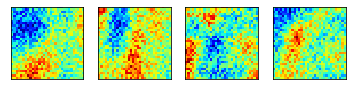

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 1, 128, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 128, 128)       4100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 128, 128)       0         
Total params: 4,100
Trainable params: 4,100
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
from keras.models import Model
model = load_model('cnn.h5')

model_visualization(model, conv_layer_number=0)

model = Model(inputs=model.inputs, outputs=model.layers[1].output)
print(model.summary())


(1, 4, 128, 128)


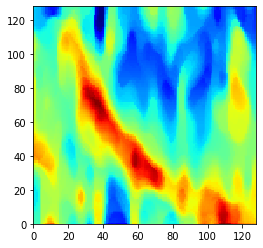

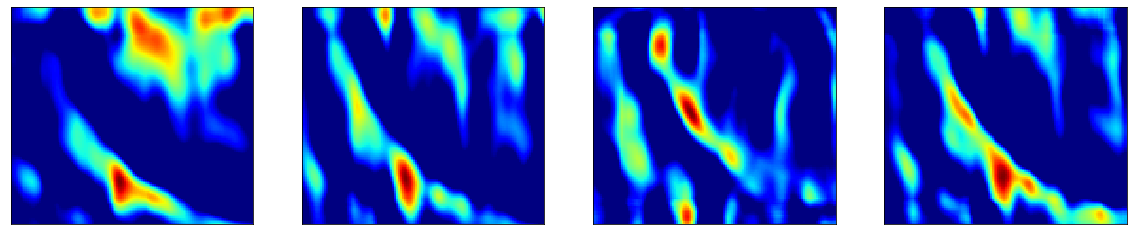

In [16]:
k = np.random.randint(len(data))
example = np.array([data[k]])
feature_maps = model.predict(example)
print(feature_maps.shape)
plt.figure(figsize=(4,4))
plt.pcolormesh(example[0][0], cmap='jet')
plt.figure(figsize=(20,4))
for i in range(feature_maps.shape[1]):
    ax = plt.subplot(1,feature_maps.shape[1],i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.pcolormesh(feature_maps[0, i, :, :], cmap='jet')